In [127]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable           Type              Data/Info
----------------------------------------------
dvMathcalP         LinearIOSystem    <LinearIOSystem>: sys[120<...>[[0. 0.]\n     [0. 0.]]\n
extMathcalP        LinearIOSystem    <LinearIOSystem>: sys[119<...> [0. 0.]\n     [0. 0.]]\n
fullOrder          int               80
hsvDvMathcalP      ndarray           80: 80 elems, type `float64`, 640 bytes
hsvExtMathcalP     ndarray           80: 80 elems, type `float64`, 640 bytes
idx_results_list   list              n=25
mathcalP_cb        LinearIOSystem    <LinearIOSystem>: sys[6]\<...>[[0. 0.]\n     [0. 0.]]\n
reducOrder         int               5
truncDvMathcalP    LinearIOSystem    <LinearIOSystem>: sys[83]<...>[[0. 0.]\n     [0. 0.]]\n
truncExtMathcalP   LinearIOSystem    <LinearIOSystem>: sys[82]<...> [0. 0.]\n     [0. 0.]]\n


In [128]:
import numpy
import sympy
import scipy
import control
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

import multiprocessing
from joblib import Parallel, delayed  
from tqdm.notebook import tqdm
import psutil

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

In [129]:
s = control.TransferFunction.s
def smallgain_condition(Tsam,mathcalC,extMathcalP,reduction_order):
        # Norm operator Delta
        normInfDelta = 2*Tsam/numpy.pi
        # Discretizing controller and computing norm of widetildeMathcalCs
        # overlineMathcalC = control.tf2ss(control.sample_system(control.ss2tf(mathcalC), Tsam, 'zoh'))
        # overlineMathcalC = control.sample_system(mathcalC, Tsam, 'zoh')
        mathcalCPrime = control.ss(mathcalC.A,mathcalC.B,mathcalC.C,numpy.zeros(mathcalC.D.shape))
        tfMathcalCPrime = control.ss2tf(mathcalCPrime)
        gamma_dv_tildew = normInfDelta * ControlUtils.hinfnorm(mathcalC) \
                                + normInfDelta * ControlUtils.hinfnorm(s * tfMathcalCPrime) * normInfDelta \
                                + ControlUtils.hinfnorm(tfMathcalCPrime) * normInfDelta 
        #######################################################################                        
        # Creating closed-loop
        # Controller matrices
        Ac = mathcalC.A
        Bv = mathcalC.B
        Cw = mathcalC.C
        Dw = mathcalC.D
        #######################################################################
        # FOM extended plant
        Ap = extMathcalP.A
        Bw = extMathcalP.B[:,0:1]
        Bu = extMathcalP.B[:,1:2]
        Cv = extMathcalP.C[0:1,:]
        Cy = extMathcalP.C[-1:,:]
        Dv = extMathcalP.D[0:1,:]
        Dy = extMathcalP.D[-1:,:]
        # Closed-loop with FOM Extended Plant
        extAcl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                                    numpy.column_stack( [ Bv@Cv, Ac ] )
                                    ] )
        extBcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                                    ] )
        extCcl = numpy.row_stack( [ numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                                    numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        extDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                                    numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                                    numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                                    ] )
        extMathcalPcl = control.ss(extAcl,extBcl,extCcl,extDcl)
        #######################################################################
        # Perform reduction to obtain ROM extended plant
        truncExtMathcalP, hsvExtMathcalP, _ = ControlUtils.balaced_truncation(extMathcalP, reduction_order)
        normInfTruncExtMathcalP = ControlUtils.hinfnorm(truncExtMathcalP)
        display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}} \\rVert_{\\infty} = ' + str(normInfTruncExtMathcalP)))
        
        truncExtAp = truncExtMathcalP.A
        truncExtBw = truncExtMathcalP.B[:,0:1]
        truncExtBu = truncExtMathcalP.B[:,1:2]
        truncExtCv = truncExtMathcalP.C[0:1,:]
        truncExtCy = truncExtMathcalP.C[-1:,:]
        truncExtDv = truncExtMathcalP.D[0:1,:]
        truncExtDy = truncExtMathcalP.D[-1:,:]
        # Closed-loop with ROM Extended Plant
        truncExtAcl = numpy.row_stack( [ numpy.column_stack( [ truncExtAp + truncExtBw@Dw@truncExtCv, truncExtBw@Cw ] ),
                                    numpy.column_stack( [ Bv@truncExtCv, Ac ] )
                                    ] )
        truncExtBcl = numpy.row_stack( [ numpy.column_stack([truncExtBw, truncExtBu]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (Ac.shape[0],truncExtBu.shape[1]) ) ] )
                                    ] )
        truncExtCcl = numpy.row_stack( [ numpy.column_stack( [ truncExtCv, numpy.zeros( (truncExtCv.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ truncExtCv@truncExtAp + truncExtCv@truncExtBw@Dw@truncExtCv, truncExtCv@truncExtBw@Cw ] ),
                                    numpy.column_stack( [ truncExtCy, numpy.zeros( (truncExtCy.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        truncExtDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (truncExtCv.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCv.shape[0],truncExtBu.shape[1]) ) ] ),
                                    numpy.column_stack( [ truncExtCv@truncExtBw , truncExtCv@truncExtBu] ),
                                    numpy.column_stack( [ numpy.zeros( (truncExtCy.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCy.shape[0],truncExtBu.shape[1]) ) ] )
                                    ] )
        truncExtMathcalPcl = control.ss(truncExtAcl,truncExtBcl,truncExtCcl,truncExtDcl)
        
        #######################################################################
        
        # Computing approximation error (Other form is to use the max hsvExtMathcalP)
        approxErrorExtMathcalPcl = extMathcalPcl-truncExtMathcalPcl
        
        #######################################################################
        # Computing norms for small-gain stability condition
        gamma_tildew_dv = ControlUtils.hinfnorm(extMathcalPcl[1,0])
        epsilon_tildew_dv = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[1,0])
        return (gamma_tildew_dv,epsilon_tildew_dv,gamma_dv_tildew,extMathcalPcl,truncExtMathcalPcl,approxErrorExtMathcalPcl,hsvExtMathcalP)

In [130]:
# Loop parameters
# kp_kd_steps = 5
# kps = numpy.linspace(75.0e-6, 100.0e-6, kp_kd_steps)
# tds = numpy.linspace(10.0e0, 10.0e0, kp_kd_steps)
# N = 1.0e3

samplings_lims = [900.0e-3,920.0e-3]
samplings_steps = 50
samplings = numpy.linspace(samplings_lims[0],samplings_lims[1],samplings_steps)

reduction_order_lims = [5,40]
# reduction_order_steps = 5
reduction_order_steps = reduction_order_lims[1]-reduction_order_lims[0]+1
reduction_orders = numpy.linspace(reduction_order_lims[0],reduction_order_lims[1],reduction_order_steps)
# print(reduction_orders)

# Fixed controller
Kp = 80e-6
Td = 10e0
N = 1.0e3
num =  [ Kp*((Td/N)+Td), Kp ]
den = [ (Td/N), 1 ]
mathcalC = control.tf2ss(num,den)

# Creation of arguements lists for the parallel execution of function smallgain_condition(*args)
idx_args_list = []
for i in range(samplings_steps):
    for j in range(reduction_order_steps):
        Tsam = samplings[i]
        reduc_order = reduction_orders[j]
        # Kp = kps[j]
        # Td = tds[j]
        
        # num =  [ (Kp/Td) * N * (N + Td), (Kp/Td) * N * (1.0/Td) ]
        # den = [ 1, N/Td ]
        # num =  [ Kp*((Td/N)+Td), Kp ]
        # den = [ (Td/N), 1 ]
        # mathcalC = control.tf2ss(num,den)

        idx_args_list.append([(i,j),(Tsam,mathcalC,extMathcalP,int(reduc_order))])

# Execution of jobs using multiprocess managed by Parallel 
# (Very recommended since standard python multithread does not take advantage of all cores due to GIL)
# (The other option is to use CPython)
num_cores = multiprocessing.cpu_count()
idx_results_list = Parallel(n_jobs=num_cores)\
                        (\
                            delayed( lambda idx,args: (idx, smallgain_condition(*args)) )\
                                ( idx_args_list[k][0], idx_args_list[k][1] )\
                                for k in tqdm(range(len(idx_args_list)), position=0)\
                        )
                

  0%|          | 0/1800 [00:00<?, ?it/s]

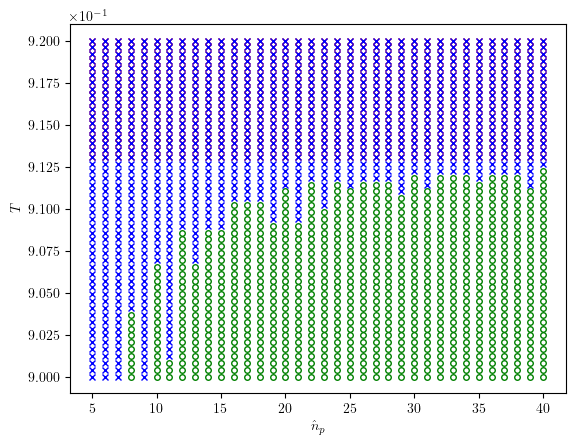

In [134]:
for k in range(len(idx_results_list)):
        # (gamma_tildew_dv,epsilon_tildew_dv,gamma_dv_tildew,extMathcalPcl,truncExtMathcalPcl,approxErrorExtMathcalPcl,hsvExtMathcalP)
    (i,j),(gamma_tildew_dv,epsilon_tildew_dv,gamma_dv_tildew,extMathcalPcl,truncExtMathcalPcl,approxErrorExtMathcalPcl,hsvExtMathcalP) = idx_results_list[k]
    
    Tsam = samplings[i]
    Tsam = samplings[i]
    reduc_order = reduction_orders[j]
    
    # epsilon_tildew_dv = sum(hsvExtMathcalP[reduc_order+1:])
    small_gain_cond_FOM = gamma_tildew_dv*gamma_dv_tildew
    small_gain_cond_ROM = (gamma_tildew_dv+epsilon_tildew_dv)*gamma_dv_tildew

    if(small_gain_cond_FOM>=1):
         plt.plot(reduc_order, Tsam, marker="x", markersize=4, markerfacecolor='r', markeredgecolor='r')
    if(small_gain_cond_ROM>=1):
        plt.plot(reduc_order, Tsam, marker="x", markersize=4, markerfacecolor='b', markeredgecolor='b')
    else:
        plt.plot(reduc_order, Tsam, marker="o", markersize=4, markerfacecolor='none', markeredgecolor='g')

plt.ticklabel_format(axis='y', scilimits=(-0,-0))
# plt.ticklabel_format(axis='x', scilimits=(0,1))
plt.ylabel('$T$')
plt.xlabel('$\\hat{n}_p$')
plt.show()

In [132]:
%store -d idx_results_list
%store idx_results_list

Stored 'idx_results_list' (list)
